# Recomendação de imóveis para compra

<p align=center>
<img src="https://i.imgur.com/a04myX9.jpg" width="10%"></p>
<p align=center>Design by: Chubarovalexandr</p>

O projeto aqui descrito tem como objetivo criar modelo de machine learning que consiga de forma eficaz recomendar imóveis para comprar na cidade.

## Dados do projeto

Os dados foram obtidos a partir de scraping de um grande website, foi utilizado o Scrapy para fazer esse processo, acesso o github para ter acesso ao código desenvolvido.
Após a extração dos dados, foi criado um WebApp com [OutSystems](www.outsystems.com) para que seja possível criar os labels dos imóveis, que o modelo irá aprender os padrões.

Abaixo é uma demonstração de como funciona o app.

<img src="https://i.imgur.com/LvdmRkV.gif" width="80%"></p>

In [1]:
# import de todas as bibliotecas usadas no projeto
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [36]:
def read_sqlite(db, table_name):
  """
  Entrada: arquivo do database e o nome da tabela.
  Função responsável por criar conexão com o banco de dados SQLite, extração dos dados e transformação da coluna bairro.
  Retorna um dataframe do pandas.
  """
  conn = sqlite3.connect(db)

  query = "select a.preco,a.area,a.quartos,a.garagem ,a.banheiros,case when a.split2 like '%Uberlândia' then a.split1 else a.split2 end as bairro from (select *,substr(endereco,1, t.pos-1) as split1,substr(endereco, t.pos+1) as split2 from(select *, instr(endereco, ', ') as pos from udi_imoveis) t) a"

  df = pd.read_sql_query(query, conn)

  return df

def preprocess_df(df):
  """
  Entrada: dataframe do pandas.
  Função responsável por preprocessing dos dados.
  Retorna um dataframe do pandas.
  """
  df.dropna(inplace = True)
  df['bairro'] = df['bairro'].str.strip()
  df['preco'] = df['preco'].str.lstrip('R$ ')
  df['area'] = df['area'].str.rstrip('m²')
  df.drop(df.index[[1,2,5]], inplace=True)
  df = df.replace(r'^\s*$', np.nan, regex=True)
  df.dropna(inplace = True)
  df['preco'] = df['preco'].str.replace(".","").astype(float)
  df['preco'] = pd.to_numeric(df['preco'])
  df['area'] = pd.to_numeric(df['area'])
  df['quartos'] = pd.to_numeric(df['quartos'])
  df['garagem'] = pd.to_numeric(df['garagem'])
  df['banheiros'] = pd.to_numeric(df['banheiros'])
  df.reset_index(inplace = True, drop = True)
  return df

In [37]:
# leitura dos dados
db = '/home/matheus/Documentos/house-recommendation/data/db_udi_imoveis.sqlite3'
df = read_sqlite (db, 'udi_imoveis')

In [38]:
df.shape

(6672, 6)

In [39]:
# aplicação do preprocess
df = preprocess_df(df)

In [40]:
df.shape

(2692, 6)

# Análise Exploratória do Dados

Essa etapa é de suma importância em um projeto de dados, ele tem como objetivo criar uma contextualização inicial e permite o entendimento do comportamento dos dados. O tamanho do conjunto de dados não é grande, mas esse processo é usual para retirar insights dos dados e descobrir algum problema nos dados.

#### Dicionário dos Dados:

* preco: preço do imóvel anunciado
* area: metragem do imóvel em metros quadrados
* quartos: quantidade de quartos no imóvel anunciado
* garagem: quantidade de garagem no imóvel anunciado
* banheiros: quantidade de banheiros no imóvel anunciado
* bairro: nome do bairro onde o imóvel anunciado está localizado

In [4]:
df.dtypes

Id            int64
area          int64
quartos       int64
garagem       int64
banheiros     int64
bairro       object
preco         int64
y            object
dtype: object

In [5]:
df.head()

,Id,area,quartos,garagem,banheiros,bairro,preco,y
0,4,185,4,2,4,Centro,700000,0
1,5,240,5,2,3,Jardim Das Palmeiras,325000,0
2,6,74,2,2,2,Copacabana,340000,0
3,7,250,3,1,3,Canaa,750000,0
4,8,45,2,1,1,Jardim Holanda,135000,0


In [6]:
df.describe()

,Id,area,quartos,garagem,banheiros,preco
count,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1.794000e+03
mean,897.500000,164.315496,2.743590,1.942029,2.099777,3.872505e+05
std,518.027509,214.364823,0.949374,1.248752,1.051157,3.261534e+05
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000e+00
25%,449.250000,61.000000,2.000000,1.000000,1.000000,1.900000e+05
50%,897.500000,94.000000,3.000000,2.000000,2.000000,2.800000e+05
75%,1345.750000,250.000000,3.000000,2.000000,2.000000,4.465000e+05
max,1794.000000,5000.000000,20.000000,16.000000,10.000000,3.500000e+06


Com os dados acima podemos retirar algumas informações sobre os dados. Por exemplo, temos que a maior área de um imóvel é de 5000 metros quadrados, mas a maioria dos dados estão até 250 metros quadrados, portanto temos um outlier.

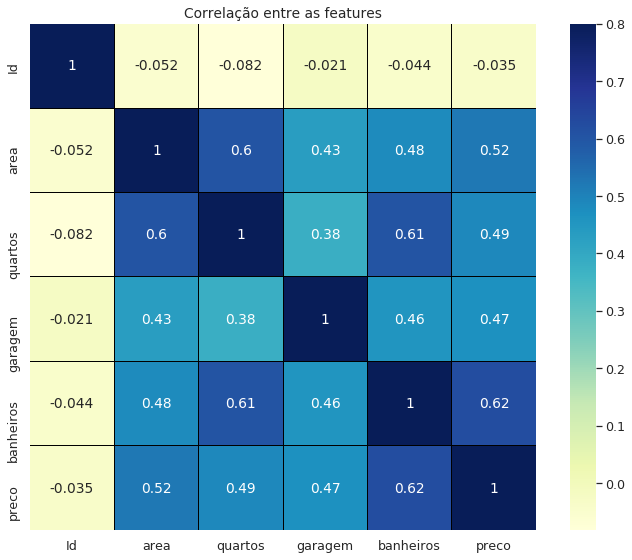

In [7]:
corr = df.corr()

sns.set(font_scale = 1.15)
plt.figure(figsize = (10, 8))

sns.heatmap(corr , vmax = .8, linewidths = 0.01, square = True, annot = True, cmap = 'YlGnBu', linecolor = 'black')
plt.title('Correlação entre as features')
plt.tight_layout()

O gráfico acima nos mostra a correlação entre as features do nosso conjunto de dados, interessante saber que o Preço tem uma correlação importante entre Área e Banheiros.

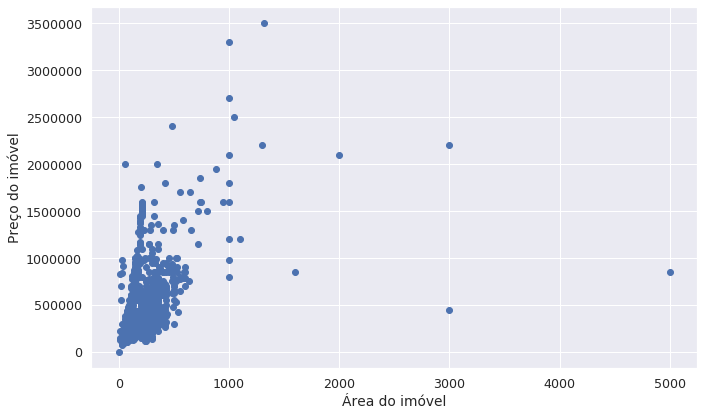

In [8]:
plt.figure(figsize = (10, 6))
plt.scatter(x = 'area', y = 'preco', data = df)
plt.xlabel('Área do imóvel')
plt.ylabel('Preço do imóvel')
plt.tight_layout()

O gráfico scatter plot acima é mostrado a distribuição dos valores entre Preço e Área. Fica evidenciado alguns outliers e também podemos perceber a concentração dos imóveis, entre 100 e 200 metros quadrados no valor de até R$500.000.

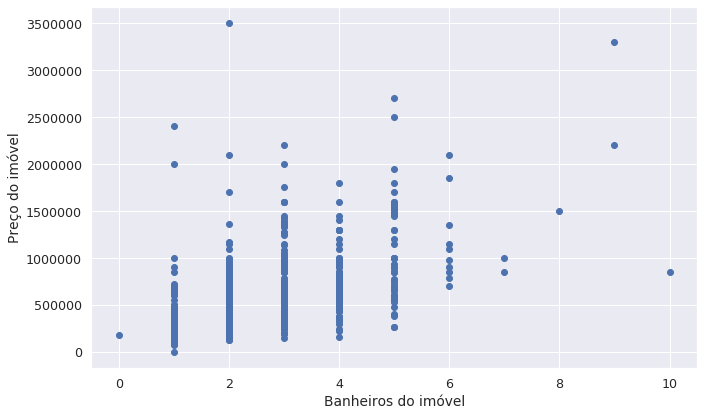

In [9]:
plt.figure(figsize = (10, 6))
plt.scatter(x = 'banheiros', y = 'preco', data = df)
plt.xlabel('Banheiros do imóvel')
plt.ylabel('Preço do imóvel')
plt.tight_layout()

Na distribuição acima, podemos perceber que, quanto mais banheiro tem no imóvel, mas caro ele é. Além disso, também vemos que há uma concentração nos imóveis que tem 1 e 2 imóveis.

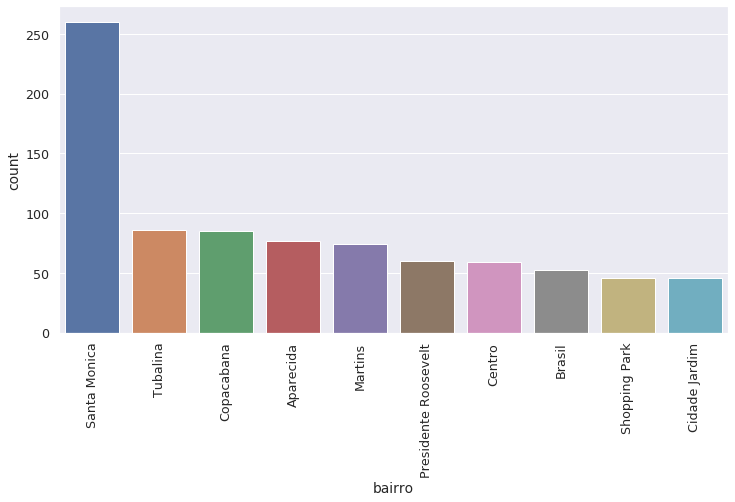

In [10]:
plt.figure(figsize = (12, 6))
plt.xlim(0, 10)
sns.countplot(x = 'bairro', data = df, order = df['bairro'].value_counts().head(10).index)
xt = plt.xticks(rotation=90)

O gráfico acima temos a quantidade de imóveis divido por bairro, e vemos que a grande maioria estão no bairro Santa Mônica, talvez seja um problema para o algoritmo.

[]

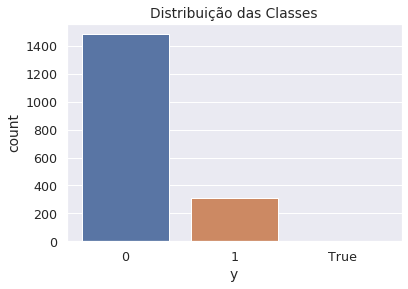

In [16]:
df['y'].value_counts()

# plotar gráfico de barras
fig, ax = plt.subplots()
sns.countplot('y', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot()

### Considerações Finais

Com essa rápida análise podemos tirar alguns __insights__ sobre os dados:

* Existe a presença de outliers
* Existe uma correlação aceitável entre as features
* A granda maioria dos dados estão concentrados em um bairro
* Existe um dado para as classes incorreto, sendo o valor True, necessário alguma ação